# 1. Training Example

## Step 0. import packages

In [1]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader
from datasets import load_from_disk #, load_dataset, Dataset
import pandas as pd
from torch.utils.data import DataLoader
import torch
from mocose import *
from transformers import BertConfig
from mocose_tools import MoCoSETrainer
from transformers.trainer import TrainingArguments

import torch.nn.functional as F

## Step 1.1. Load Dataset from checkpoint

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 64
train_dataset = load_from_disk("F:\\Models\\temp\\wiki_for_sts_32")
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last = True)

## Step 1.2. Load Dataset with raw data

In [3]:
# datasets = load_dataset("text", data_files="F:\\Experiment\MoCoSE\codes\data\wiki1m_for_simcse.txt", cache_dir="F:\\Experiment\\MoCoSE\\codes\\data")

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# prepare_features(datasets)

## Setp 1.3. init model

In [4]:
config = BertConfig()
config.out_size=768
config.mlp_layers=2
config.proj_layers=1

config.fgsm = 5e-9
config.embedding_drop_prob = 0.1
config.token_drop_prob = 0
config.feature_drop_prob = 0
config.token_shuffle = False
config.contextual_wordembs_aug = False

config.age_test = False

config.K = 256
config.K_start = 128
config.ema_decay = 0.75


config.neg_queue_slice_span = 256 # euqal to batch size, won't work if age_test=False

with open(r'F:\Experiment\MoCoSE\codes\pretrained_bert\bert-base-uncased\vocab.txt','r',encoding='utf8') as f:
    test_untokenizer = f.readlines()
untokenizer = [i[:-1] for i in test_untokenizer]
config.untokenizer = untokenizer

model = MoCoSEModel(config)
model.online_embeddings.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\embeddings.pth'))
model.online_encoder.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\encoder.pth'))
model.online_pooler.dense.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\pooler_dense.pth'))

model.prepare()
model = model.cuda()

non_optimizer_list = [model.target_encoder,model.target_pooler]
for layer in non_optimizer_list:
    for para in layer.parameters():
        para.requires_grad = False

### Setp 1.3.1 add calculation methods of aliment and uniformity

In [3]:
def align_loss(x, y, alpha=2):    
    return (x - y).norm(p=2, dim=1).pow(alpha).mean()

def uniform_loss(x, t=2):
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()

def get_pair_emb(model, input_ids, attention_mask,token_type_ids):    
    outputs = model(input_ids = input_ids.cuda(),attention_mask=attention_mask.cuda(),token_type_ids=token_type_ids.cuda(),sent_emb=True)
    pooler_output = outputs.last_hidden_state[:,0]     
    #pooler_output = outputs.pooler_output
    z1, z2 = pooler_output[:batch_size], pooler_output[batch_size:]
    return z1.cpu(),z2.cpu()

def get_align(model, dataloader):
    align_all = []
    with torch.no_grad():        
        for data in dataloader:
            input_ids = torch.cat((data['input_ids'][0],data['input_ids'][1]))
            attention_mask = torch.cat((data['attention_mask'][0],data['attention_mask'][1]))
            token_type_ids = torch.cat((data['token_type_ids'][0],data['token_type_ids'][1]))

            z1,z2 = get_pair_emb(model, input_ids, attention_mask, token_type_ids)  
            z1 = F.normalize(z1,dim=1)
            z2 = F.normalize(z2,dim=1)
            align_all.append(align_loss(z1, z2))
            
    return align_all
    
def get_unif(model, dataloader):
    unif_all = []
    with torch.no_grad():        
        for data in dataloader:
            input_ids = torch.cat((data['input_ids'][0],data['input_ids'][1]))
            attention_mask = torch.cat((data['attention_mask'][0],data['attention_mask'][1]))
            token_type_ids = torch.cat((data['token_type_ids'][0],data['token_type_ids'][1]))
            z1,z2 = get_pair_emb(model, input_ids, attention_mask, token_type_ids)   
            #z = torch.cat((z1,z2))
            z = z1
            z = F.normalize(z,p=2,dim=1)
            unif_all.append(uniform_loss(z, t=2))
            
    return unif_all

## Step 1.4. set train arguments

In [6]:
args = TrainingArguments(
    output_dir = 'F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose_base_out\\',
    evaluation_strategy   = "steps",
    eval_steps            = 175,
    learning_rate         = 3e-5,
    num_train_epochs      = 1.0,
    weight_decay          = 1e-6,
    per_device_train_batch_size = 256,
    per_device_eval_batch_size  = 256,
    dataloader_drop_last = True,
)
trainer = MoCoSETrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

In [4]:
pos_dataset = load_from_disk("F:\\Experiment\\MoCoSE\\codes\\data\\uniform_align_data\\stsb_pos")
pos_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])
pos_loader = DataLoader(pos_dataset, batch_size = batch_size, drop_last = True)

all_dataset = load_from_disk("F:\\Experiment\\MoCoSE\\codes\\data\\uniform_align_data\\stsb_all")
all_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])
all_loader = DataLoader(all_dataset, batch_size = batch_size, drop_last = True)

In [8]:
trainer.train()

model_ = MoCoSEModel.from_pretrained('F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose_base_out\\best-model')
model_ = model_.cuda()
align_all = get_align(model_, all_loader)
align_pos = get_align(model_, pos_loader)
uniform_all = get_unif(model_, all_loader)
uniform_pos = get_unif(model_, pos_loader)

all_loader_align = sum(align_all)/len(align_all)
pos_loader_align = sum(align_pos)/len(align_pos)

all_loader_uniformity = sum(uniform_all)/len(uniform_all)
pos_loader_uniformity = sum(uniform_pos)/len(uniform_pos)
print("--------------alignment & uniformity-----------------")
print("all_loader_align",all_loader_align)
print("pos_loader_align",pos_loader_align)
print("all_loader_uniformity",all_loader_uniformity)
print("pos_loader_uniformity",pos_loader_uniformity)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 995447
  Num Epochs = 1
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 3888
  5%|▍         | 175/3888 [03:16<1:08:27,  1.11s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 29.77 | 48.80 | 41.32 | 51.11 | 57.12 |    32.64     |      46.65      | 43.92 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 43.91625 
max acc  43.91625


  9%|▉         | 350/3888 [07:08<1:04:34,  1.10s/it] Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 56.44 | 69.74 | 61.81 | 73.13 | 69.91 |    64.62     |      68.67      | 66.33 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 66.33125 
max acc  66.33125


 13%|█▎        | 500/3888 [10:31<1:00:54,  1.08s/it] Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\config.json


{'loss': 1.5761, 'learning_rate': 2.6141975308641973e-05, 'epoch': 0.13}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\special_tokens_map.json
 14%|█▎        | 525/3888 [11:00<1:00:26,  1.08s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 62.00 | 75.53 | 67.46 | 77.24 | 74.67 |    71.90     |      72.27      | 71.58 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 71.58125000000001 
max acc  71.58125000000001


 18%|█▊        | 700/3888 [14:50<57:48,  1.09s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 64.15 | 77.48 | 69.29 | 78.53 | 76.17 |    74.38     |      73.04      | 73.29 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 73.29125 
max acc  73.29125


 23%|██▎       | 875/3888 [18:44<54:29,  1.09s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 65.38 | 78.77 | 70.51 | 80.08 | 77.02 |    75.93     |      73.36      | 74.44 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 74.43625 
max acc  74.43625


 26%|██▌       | 1000/3888 [21:39<51:36,  1.07s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\config.json


{'loss': 0.0196, 'learning_rate': 2.2283950617283953e-05, 'epoch': 0.26}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\special_tokens_map.json
 27%|██▋       | 1050/3888 [22:35<51:08,  1.08s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 66.85 | 79.79 | 71.91 | 81.20 | 78.06 |    77.27     |      73.16      | 75.46 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 75.4625 
max acc  75.4625


 32%|███▏      | 1225/3888 [26:25<48:45,  1.10s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 67.96 | 80.66 | 72.60 | 81.98 | 78.54 |    78.16     |      73.01      | 76.13 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.13 
max acc  76.13


 36%|███▌      | 1400/3888 [30:14<45:06,  1.09s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.48 | 80.96 | 73.00 | 82.41 | 78.80 |    78.53     |      72.66      | 76.41 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.40625 
max acc  76.40625


 39%|███▊      | 1500/3888 [32:48<44:23,  1.12s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\config.json


{'loss': 0.0096, 'learning_rate': 1.8425925925925926e-05, 'epoch': 0.39}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\special_tokens_map.json
 41%|████      | 1575/3888 [34:12<42:57,  1.11s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.80 | 80.94 | 73.40 | 82.58 | 78.79 |    78.72     |      72.58      | 76.54 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.54375 
max acc  76.54375


 45%|████▌     | 1750/3888 [38:02<38:26,  1.08s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.40 | 81.41 | 73.63 | 82.75 | 79.08 |    78.89     |      72.19      | 76.76 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.76374999999999 
max acc  76.76374999999999


 50%|████▉     | 1925/3888 [41:52<35:32,  1.09s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.46 | 81.50 | 73.77 | 82.77 | 79.22 |    78.97     |      72.17      | 76.84 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.83749999999999 
max acc  76.83749999999999


 51%|█████▏    | 2000/3888 [43:54<34:09,  1.09s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\config.json


{'loss': 0.0064, 'learning_rate': 1.4567901234567902e-05, 'epoch': 0.51}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\special_tokens_map.json
 54%|█████▍    | 2100/3888 [45:45<33:34,  1.13s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.46 | 81.43 | 73.90 | 82.71 | 79.18 |    78.80     |      71.92      | 76.77 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.77125 
max acc  76.83749999999999


 59%|█████▊    | 2275/3888 [49:35<29:02,  1.08s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.26 | 81.07 | 73.64 | 82.51 | 79.12 |    78.64     |      71.96      | 76.60 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.6 
max acc  76.83749999999999


 63%|██████▎   | 2450/3888 [53:23<25:40,  1.07s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.44 | 81.08 | 73.82 | 82.58 | 79.19 |    78.77     |      71.77      | 76.66 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.66375 
max acc  76.83749999999999


 64%|██████▍   | 2500/3888 [54:55<24:41,  1.07s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\config.json


{'loss': 0.0051, 'learning_rate': 1.0709876543209878e-05, 'epoch': 0.64}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\special_tokens_map.json
 68%|██████▊   | 2625/3888 [57:13<23:06,  1.10s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.61 | 81.27 | 73.97 | 82.69 | 79.34 |    78.91     |      71.73      | 76.79 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.78875 
max acc  76.83749999999999


 72%|███████▏  | 2800/3888 [1:01:04<20:31,  1.13s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.31 | 81.29 | 73.97 | 82.69 | 79.23 |    78.81     |      71.62      | 76.70 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.70250000000001 
max acc  76.83749999999999


 77%|███████▋  | 2975/3888 [1:04:54<16:28,  1.08s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.12 | 81.21 | 73.89 | 82.67 | 79.11 |    78.77     |      71.74      | 76.64 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.64375 
max acc  76.83749999999999


 77%|███████▋  | 3000/3888 [1:06:00<15:50,  1.07s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\config.json


{'loss': 0.0045, 'learning_rate': 6.851851851851852e-06, 'epoch': 0.77}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\special_tokens_map.json
 81%|████████  | 3150/3888 [1:08:45<13:17,  1.08s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.23 | 81.05 | 73.78 | 82.57 | 78.89 |    78.52     |      71.58      | 76.52 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.5175 
max acc  76.83749999999999


 86%|████████▌ | 3325/3888 [1:12:33<10:04,  1.07s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.14 | 80.93 | 73.77 | 82.47 | 78.82 |    78.45     |      71.45      | 76.43 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.4325 
max acc  76.83749999999999


 90%|█████████ | 3500/3888 [1:16:23<07:06,  1.10s/it]  

{'loss': 0.0039, 'learning_rate': 2.9938271604938273e-06, 'epoch': 0.9}


Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.24 | 80.88 | 73.69 | 82.45 | 78.91 |    78.48     |      71.46      | 76.44 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.44375 
max acc  76.83749999999999


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\special_tokens_map.json
 95%|█████████▍| 3675/3888 [1:20:15<03:51,  1.09s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.20 | 80.93 | 73.71 | 82.44 | 78.99 |    78.49     |      71.45      | 76.46 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.45875000000001 
max acc  76.83749999999999


 99%|█████████▉| 3850/3888 [1:24:03<00:42,  1.11s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.19 | 80.89 | 73.67 | 82.46 | 78.99 |    78.48     |      71.46      | 76.45 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.44875 
max acc  76.83749999999999


100%|██████████| 3888/3888 [1:25:23<00:00,  1.10s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 3888/3888 [1:25:23<00:00,  1.32s/it]
loading configuration file F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\best-model\config.json
Model config BertConfig {
  "K": 512,
  "K_start": 128,
  "age_test": false,
  "architectures": [
    "MoCoSEModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "contextual_wordembs_aug": false,
  "ema_decay": 0.75,
  "embedding_drop_prob": 0.1,
  "feature_drop_prob": 0,
  "fgsm": 5e-09,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "mlp_layers": 2,
  "model_type": "bert",
  "neg_queue_slice_span": 256,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "out_size": 768,
  "pad_token_id": 0,
  "position_em

{'train_runtime': 5123.4284, 'train_samples_per_second': 194.293, 'train_steps_per_second': 0.759, 'train_loss': 0.20939416202252784, 'epoch': 1.0}


All model checkpoint weights were used when initializing MoCoSEModel.

All the weights of MoCoSEModel were initialized from the model checkpoint at F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\best-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MoCoSEModel for predictions without further training.


--------------alignment & uniformity-----------------
all_loader_align tensor(0.3321)
pos_loader_align tensor(0.1304)
all_loader_uniformity tensor(-1.5858)
pos_loader_uniformity tensor(-1.6468)


In [7]:
config = BertConfig()
config.out_size=768
config.mlp_layers=2
config.proj_layers=1

config.fgsm = 5e-9
config.embedding_drop_prob = 0.1
config.token_drop_prob = 0
config.feature_drop_prob = 0
config.token_shuffle = False
config.contextual_wordembs_aug = False

config.age_test = False

config.K = 256
config.K_start = 128
config.ema_decay = 0.85


config.neg_queue_slice_span = 256 # euqal to batch size, won't work if age_test=False

with open(r'F:\Experiment\MoCoSE\codes\pretrained_bert\bert-base-uncased\vocab.txt','r',encoding='utf8') as f:
    test_untokenizer = f.readlines()
untokenizer = [i[:-1] for i in test_untokenizer]
config.untokenizer = None

model = MoCoSEModel(config)
model.online_embeddings.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\embeddings.pth'))
model.online_encoder.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\encoder.pth'))
model.online_pooler.dense.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\pooler_dense.pth'))

model.prepare()
model = model.cuda()

non_optimizer_list = [model.target_encoder,model.target_pooler]
for layer in non_optimizer_list:
    for para in layer.parameters():
        para.requires_grad = False

args = TrainingArguments(
    output_dir = 'F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose_base_out\\',
    evaluation_strategy   = "steps",
    eval_steps            = 175,
    learning_rate         = 3e-5,
    num_train_epochs      = 1.0,
    weight_decay          = 1e-6,
    per_device_train_batch_size = 256,
    per_device_eval_batch_size  = 256,
    dataloader_drop_last = True,
)
trainer = MoCoSETrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

trainer.train()
model_ = MoCoSEModel.from_pretrained('F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose_base_out\\best-model')
model_ = model_.cuda()
align_all = get_align(model_, all_loader)
align_pos = get_align(model_, pos_loader)
uniform_all = get_unif(model_, all_loader)
uniform_pos = get_unif(model_, pos_loader)

all_loader_align = sum(align_all)/len(align_all)
pos_loader_align = sum(align_pos)/len(align_pos)

all_loader_uniformity = sum(uniform_all)/len(uniform_all)
pos_loader_uniformity = sum(uniform_pos)/len(uniform_pos)
print("--------------alignment & uniformity-----------------")
print("all_loader_align",all_loader_align)
print("pos_loader_align",pos_loader_align)
print("all_loader_uniformity",all_loader_uniformity)
print("pos_loader_uniformity",pos_loader_uniformity)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 995447
  Num Epochs = 1
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 3888
  5%|▍         | 175/3888 [03:12<1:09:38,  1.13s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 28.80 | 52.23 | 41.51 | 53.05 | 57.12 |    31.06     |      47.52      | 44.47 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 44.47 
max acc  44.47


  9%|▉         | 350/3888 [07:08<1:07:09,  1.14s/it] Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 52.06 | 67.19 | 57.39 | 70.63 | 68.16 |    57.48     |      66.21      | 62.73 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 62.731249999999996 
max acc  62.731249999999996


 13%|█▎        | 500/3888 [10:38<1:02:51,  1.11s/it] Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\config.json


{'loss': 1.3094, 'learning_rate': 2.6141975308641973e-05, 'epoch': 0.13}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\special_tokens_map.json
 14%|█▎        | 525/3888 [11:08<1:01:27,  1.10s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 56.68 | 71.92 | 63.17 | 75.15 | 71.58 |    64.73     |      69.82      | 67.58 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 67.57875 
max acc  67.57875


 18%|█▊        | 700/3888 [15:02<59:01,  1.11s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 59.91 | 74.59 | 66.34 | 77.40 | 74.02 |    68.62     |      71.58      | 70.35 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 70.35125 
max acc  70.35125


 23%|██▎       | 875/3888 [18:56<55:26,  1.10s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 61.49 | 75.91 | 68.25 | 78.51 | 75.25 |    71.36     |      72.36      | 71.88 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 71.87625 
max acc  71.87625


 26%|██▌       | 1000/3888 [21:59<54:46,  1.14s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\config.json


{'loss': 0.0177, 'learning_rate': 2.2283950617283953e-05, 'epoch': 0.26}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\special_tokens_map.json
 27%|██▋       | 1050/3888 [22:58<53:47,  1.14s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 62.35 | 76.97 | 69.27 | 79.39 | 76.34 |    72.83     |      72.25      | 72.77 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 72.77125 
max acc  72.77125


 32%|███▏      | 1225/3888 [26:56<49:50,  1.12s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 64.17 | 78.07 | 70.39 | 80.21 | 77.10 |    74.70     |      72.13      | 73.82 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 73.82374999999999 
max acc  73.82374999999999


 36%|███▌      | 1400/3888 [30:53<46:20,  1.12s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 65.00 | 78.83 | 70.95 | 80.85 | 77.47 |    75.85     |      72.38      | 74.48 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 74.47625000000001 
max acc  74.47625000000001


 39%|███▊      | 1500/3888 [33:26<44:17,  1.11s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\config.json


{'loss': 0.0093, 'learning_rate': 1.8425925925925926e-05, 'epoch': 0.39}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\special_tokens_map.json
 41%|████      | 1575/3888 [34:52<43:59,  1.14s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 66.32 | 79.41 | 71.68 | 81.52 | 77.99 |    77.05     |      72.14      | 75.16 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 75.15875 
max acc  75.15875


 45%|████▌     | 1750/3888 [38:54<42:01,  1.18s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 66.81 | 79.69 | 72.15 | 81.78 | 78.34 |    77.52     |      72.07      | 75.48 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 75.47999999999999 
max acc  75.47999999999999


 50%|████▉     | 1925/3888 [42:49<37:05,  1.13s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 67.86 | 80.38 | 72.79 | 82.21 | 78.70 |    78.28     |      71.97      | 76.03 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.0275 
max acc  76.0275


 51%|█████▏    | 2000/3888 [44:54<35:24,  1.13s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\config.json


{'loss': 0.0062, 'learning_rate': 1.4567901234567902e-05, 'epoch': 0.51}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\special_tokens_map.json
 54%|█████▍    | 2100/3888 [46:49<32:41,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.63 | 80.88 | 73.49 | 82.50 | 78.92 |    78.67     |      71.82      | 76.42 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.41625 
max acc  76.41625


 59%|█████▊    | 2275/3888 [50:44<30:11,  1.12s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.43 | 80.88 | 73.47 | 82.48 | 78.95 |    78.69     |      71.84      | 76.39 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.39125 
max acc  76.41625


 63%|██████▎   | 2450/3888 [54:36<26:19,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.81 | 81.00 | 73.74 | 82.76 | 79.02 |    78.83     |      71.76      | 76.56 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.56 
max acc  76.56


 64%|██████▍   | 2500/3888 [56:11<24:57,  1.08s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\config.json


{'loss': 0.0047, 'learning_rate': 1.0709876543209878e-05, 'epoch': 0.64}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\special_tokens_map.json
 68%|██████▊   | 2625/3888 [58:30<23:57,  1.14s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.41 | 81.41 | 74.10 | 83.01 | 79.10 |    79.22     |      71.55      | 76.83 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.82875 
max acc  76.82875


 72%|███████▏  | 2800/3888 [1:02:22<19:24,  1.07s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.26 | 81.52 | 74.10 | 83.02 | 79.12 |    79.14     |      71.52      | 76.81 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.81125 
max acc  76.82875


 77%|███████▋  | 2975/3888 [1:06:12<16:26,  1.08s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.18 | 81.63 | 74.18 | 82.98 | 79.20 |    79.20     |      71.58      | 76.85 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.85000000000001 
max acc  76.85000000000001


 77%|███████▋  | 3000/3888 [1:07:20<16:24,  1.11s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\config.json


{'loss': 0.004, 'learning_rate': 6.851851851851852e-06, 'epoch': 0.77}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\special_tokens_map.json
 81%|████████  | 3150/3888 [1:10:08<13:29,  1.10s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.28 | 81.61 | 74.13 | 83.02 | 79.20 |    79.21     |      71.53      | 76.85 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.85374999999999 
max acc  76.85374999999999


 86%|████████▌ | 3325/3888 [1:14:01<10:21,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.45 | 81.60 | 74.24 | 83.04 | 79.21 |    79.21     |      71.48      | 76.89 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.89 
max acc  76.89


 90%|█████████ | 3500/3888 [1:17:53<07:06,  1.10s/it]  

{'loss': 0.0033, 'learning_rate': 2.9938271604938273e-06, 'epoch': 0.9}


Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.44 | 81.57 | 74.25 | 83.00 | 79.19 |    79.15     |      71.50      | 76.87 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.87125 
max acc  76.89


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\special_tokens_map.json
 95%|█████████▍| 3675/3888 [1:21:47<03:52,  1.09s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.44 | 81.55 | 74.23 | 82.97 | 79.22 |    79.15     |      71.50      | 76.87 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.86625000000001 
max acc  76.89


 99%|█████████▉| 3850/3888 [1:25:38<00:41,  1.08s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.45 | 81.50 | 74.22 | 82.99 | 79.22 |    79.15     |      71.49      | 76.86 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.86 
max acc  76.89


100%|██████████| 3888/3888 [1:26:58<00:00,  1.09s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 3888/3888 [1:26:58<00:00,  1.34s/it]
loading configuration file F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\best-model\config.json
Model config BertConfig {
  "K": 256,
  "K_start": 128,
  "age_test": false,
  "architectures": [
    "MoCoSEModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "contextual_wordembs_aug": false,
  "ema_decay": 0.85,
  "embedding_drop_prob": 0.1,
  "feature_drop_prob": 0,
  "fgsm": 5e-09,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "mlp_layers": 2,
  "model_type": "bert",
  "neg_queue_slice_span": 256,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "out_size": 768,
  "pad_token_id": 0,
  "position_em

{'train_runtime': 5218.4244, 'train_samples_per_second': 190.756, 'train_steps_per_second': 0.745, 'train_loss': 0.1745365717651422, 'epoch': 1.0}


All model checkpoint weights were used when initializing MoCoSEModel.

All the weights of MoCoSEModel were initialized from the model checkpoint at F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\best-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MoCoSEModel for predictions without further training.


--------------alignment & uniformity-----------------
all_loader_align tensor(0.3453)
pos_loader_align tensor(0.1367)
all_loader_uniformity tensor(-1.6391)
pos_loader_uniformity tensor(-1.7004)


##### supplementary experiment

In [6]:
model_ = MoCoSEModel.from_pretrained('F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose_base_out\\best-model')
model_ = model_.cuda()
align_all = get_align(model_, all_loader)
align_pos = get_align(model_, pos_loader)
uniform_all = get_unif(model_, all_loader)
uniform_pos = get_unif(model_, pos_loader)

all_loader_align = sum(align_all)/len(align_all)
pos_loader_align = sum(align_pos)/len(align_pos)

all_loader_uniformity = sum(uniform_all)/len(uniform_all)
pos_loader_uniformity = sum(uniform_pos)/len(uniform_pos)
print("--------------alignment & uniformity-----------------")
print("all_loader_align",all_loader_align)
print("pos_loader_align",pos_loader_align)
print("all_loader_uniformity",all_loader_uniformity)
print("pos_loader_uniformity",pos_loader_uniformity)

loading configuration file F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\best-model\config.json
Model config BertConfig {
  "K": 256,
  "K_start": 128,
  "age_test": false,
  "architectures": [
    "MoCoSEModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "contextual_wordembs_aug": false,
  "ema_decay": 0.75,
  "embedding_drop_prob": 0.1,
  "feature_drop_prob": 0,
  "fgsm": 5e-09,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "mlp_layers": 2,
  "model_type": "bert",
  "neg_queue_slice_span": 256,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "out_size": 768,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "proj_layers": 1,
  "token_drop_prob": 0,
  "token_shuffle": false,
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "untok

--------------alignment & uniformity-----------------
all_loader_align tensor(0.4324)
pos_loader_align tensor(0.1747)
all_loader_uniformity tensor(-2.0205)
pos_loader_uniformity tensor(-2.0943)


### Text augumentation experiment (ContextualWordEmbsAug, SpellingAug, ContextualWordEmbsForSentenceAug, BackTranslationAug(en<->de))

In [1]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader
from datasets import load_from_disk #, load_dataset, Dataset
import pandas as pd
from torch.utils.data import DataLoader
import torch
from mocose import *
from transformers import BertConfig
from mocose_tools import MoCoSETrainer
from transformers.trainer import TrainingArguments

import torch.nn.functional as F

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 64
train_dataset = load_from_disk("F:\\Models\\temp\\wiki_for_sts_32")
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last = True)

In [2]:
config = BertConfig()
config.out_size=768
config.mlp_layers=2
config.proj_layers=1

config.fgsm = 0 #5e-9
config.embedding_drop_prob = 0.1
config.token_drop_prob = 0
config.feature_drop_prob = 0
config.token_shuffle = False
config.contextual_wordembs_aug = True

config.age_test = False

config.K = 512
config.K_start = 128
config.ema_decay = 0.85

# 'cwea' : ContextualWordEmbsAug  roberta-base
# 'spa'  : SpellingAug
# 'cwesa': ContextualWordEmbsForSentenceAug  xlnet-base-cased
# 'bta'  : BackTranslationAug  facebook/wmt19-en-de  to  facebook/wmt19-de-en
config.text_aug_type = 'cwesa' # won't work if contextual_wordembs_aug=False

config.neg_queue_slice_span = 256 # euqal to batch size, won't work if age_test=False

model = MoCoSEModel(config)
model.online_embeddings.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\embeddings.pth'))
model.online_encoder.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\encoder.pth'))
model.online_pooler.dense.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\pooler_dense.pth'))

model.prepare()
model = model.cuda()

non_optimizer_list = [model.target_encoder,model.target_pooler]
for layer in non_optimizer_list:
    for para in layer.parameters():
        para.requires_grad = False

args = TrainingArguments(
    output_dir = 'F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose_base_out\\',
    evaluation_strategy   = "steps",
    eval_steps            = 175,
    learning_rate         = 3e-5,
    num_train_epochs      = 1.0,
    weight_decay          = 1e-6,
    per_device_train_batch_size = 256,
    per_device_eval_batch_size  = 256,
    dataloader_drop_last = True,
)
trainer = MoCoSETrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

trainer.train()

***** Running training *****
  Num examples = 995447
  Num Epochs = 1
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 3888
  5%|▍         | 175/3888 [1:01:03<22:06:16, 21.43s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 45.35 | 47.54 | 35.09 | 56.65 | 55.83 |    39.74     |      50.33      | 47.22 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 47.21875 
max acc  47.21875


  9%|▉         | 350/3888 [2:02:58<19:44:47, 20.09s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 44.88 | 48.71 | 33.94 | 53.96 | 56.24 |    42.92     |      56.72      | 48.20 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 48.19625 
max acc  48.19625


 13%|█▎        | 500/3888 [2:54:56<18:52:16, 20.05s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\config.json


{'loss': 2.3487, 'learning_rate': 2.6141975308641973e-05, 'epoch': 0.13}


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\special_tokens_map.json
 14%|█▎        | 525/3888 [3:03:34<19:58:06, 21.38s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 48.41 | 53.76 | 38.57 | 59.30 | 60.05 |    50.75     |      61.48      | 53.19 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 53.18875 
max acc  53.18875


 18%|█▊        | 700/3888 [4:04:03<18:00:43, 20.34s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 49.83 | 56.68 | 40.92 | 60.53 | 60.91 |    52.97     |      61.68      | 54.79 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 54.78875000000001 
max acc  54.78875000000001


 23%|██▎       | 875/3888 [5:04:37<16:49:54, 20.11s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 51.13 | 59.57 | 42.78 | 61.40 | 62.15 |    54.99     |      62.29      | 56.33 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 56.330000000000005 
max acc  56.330000000000005


 26%|██▌       | 1000/3888 [5:47:58<16:42:45, 20.83s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\config.json


{'loss': 0.0853, 'learning_rate': 2.2283950617283953e-05, 'epoch': 0.26}


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\special_tokens_map.json
 27%|██▋       | 1050/3888 [6:05:07<16:08:07, 20.47s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 50.81 | 61.20 | 43.87 | 62.24 | 62.51 |    55.28     |      62.35      | 56.89 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 56.89375 
max acc  56.89375


 32%|███▏      | 1225/3888 [7:05:29<15:35:31, 21.08s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 51.57 | 62.39 | 45.01 | 63.10 | 64.22 |    56.31     |      61.95      | 57.79 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 57.7925 
max acc  57.7925


 36%|███▌      | 1400/3888 [8:06:14<14:16:51, 20.66s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 51.74 | 63.12 | 45.42 | 63.75 | 64.24 |    56.48     |      62.51      | 58.18 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 58.18 
max acc  58.18


 39%|███▊      | 1500/3888 [8:41:14<13:39:43, 20.60s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\config.json


{'loss': 0.0376, 'learning_rate': 1.8425925925925926e-05, 'epoch': 0.39}


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\special_tokens_map.json
 41%|████      | 1575/3888 [9:07:19<13:31:39, 21.05s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 53.61 | 65.48 | 48.83 | 65.92 | 66.08 |    59.00     |      64.24      | 60.45 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 60.45125 
max acc  60.45125


 45%|████▌     | 1750/3888 [10:08:38<12:54:33, 21.74s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 52.11 | 62.72 | 45.10 | 64.11 | 63.37 |    56.50     |      62.40      | 58.04 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 58.04375 
max acc  60.45125


 50%|████▉     | 1925/3888 [11:09:49<10:35:42, 19.43s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 52.98 | 63.64 | 46.40 | 64.78 | 63.87 |    57.09     |      62.54      | 58.76 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 58.7575 
max acc  60.45125


 51%|█████▏    | 2000/3888 [11:36:19<10:55:52, 20.84s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\config.json


{'loss': 0.0285, 'learning_rate': 1.4567901234567902e-05, 'epoch': 0.51}


tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\special_tokens_map.json
 54%|█████▍    | 2091/3888 [12:07:54<10:25:48, 20.90s/it]

KeyboardInterrupt: 

########################## fgsm #######################
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.88 | 81.24 | 73.51 | 82.78 | 79.24 |    78.65     |      71.88      | 76.74 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
68%|██████▊   | 2625/3888 [57:18<22:43,  1.08s/it]
acc before pooler: 76.74 
max acc  76.74


########################## fgsm + contextual_wordembs_aug #######################

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 34.16 | 45.32 | 29.42 | 48.31 | 42.15 |    31.64     |      42.70      | 39.10 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 39.1 
max acc  39.49125
100%|██████████| 3888/3888 [6:24:31<00:00,  5.61s/it]


########################## contextual_wordembs_aug 'roberta-base' #######################
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 26.17 | 31.45 | 19.77 | 39.83 | 30.31 |    21.52     |      31.87      | 28.70 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 28.7025 
max acc  28.7025
结束时，avg仍然在增长


########################## SpellingAug mistake words #######################
67%|██████▋   | 2600/3888 [1:35:21<43:54,  2.05s/it]
+-------+-------+-------+------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 13.53 | 25.69 | 11.77 | 25.35 | 31.42 |    11.17     |      21.75      | 20.10 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 20.0975 
max acc  22.320000000000004


########################## fgsm + SpellingAug mistake words #######################
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 20.46 | 20.09 | 10.86 | 23.76 | 33.25 |    16.40     |      26.80      | 21.66 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 21.66 
max acc  21.66


############# ContextualWordEmbsForSentenceAug 'xlnet-base-cased' ###########
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 53.61 | 65.48 | 48.83 | 65.92 | 66.08 |    59.00     |      64.24      | 60.45 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 60.45125 
max acc  60.45125


############# fgsm + ContextualWordEmbsForSentenceAug 'xlnet-base-cased' ####
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 52.71 | 64.84 | 48.18 | 66.24 | 66.72 |    59.13     |      63.54      | 60.19 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 60.19375000000001 
max acc  60.19375000000001


########################## backtranslation en->de->en #######################
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 61.54 | 71.66 | 62.87 | 75.80 | 73.17 |    71.45     |      68.03      | 69.22 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 69.2175 
max acc  69.3475
96%|█████████▌| 3731/3888 [14:01:11<40:34, 15.51s/it]

In [1]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader
from datasets import load_from_disk #, load_dataset, Dataset
import pandas as pd
from torch.utils.data import DataLoader
import torch
from mocose import *
from transformers import BertConfig
from mocose_tools import MoCoSETrainer
from transformers.trainer import TrainingArguments

import torch.nn.functional as F

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 64
train_dataset = load_from_disk("F:\\Models\\temp\\wiki_for_sts_32")
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last = True)

In [2]:
config = BertConfig()
config.out_size=768
config.mlp_layers=2
config.proj_layers=1

config.fgsm = 0 #5e-9
config.embedding_drop_prob = 0.1
config.token_drop_prob = 0
config.feature_drop_prob = 0
config.token_shuffle = False
config.contextual_wordembs_aug = False

config.age_test = True

config.K = 1024
config.K_start = 128
config.ema_decay = 0.85

# 'cwea' : ContextualWordEmbsAug  roberta-base
# 'spa'  : SpellingAug
# 'cwesa': ContextualWordEmbsForSentenceAug  xlnet-base-cased
# 'bta'  : BackTranslationAug  facebook/wmt19-en-de  to  facebook/wmt19-de-en
config.text_aug_type = 'cwesa' # won't work if contextual_wordembs_aug=False

config.neg_queue_slice_span = 256 # euqal to batch size, won't work if age_test=False

model = MoCoSEModel(config)
model.online_embeddings.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\embeddings.pth'))
model.online_encoder.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\encoder.pth'))
model.online_pooler.dense.load_state_dict(torch.load('F:\\Models\\temp\\bert-base-uncased-weights\\pooler_dense.pth'))

model.prepare()
model = model.cuda()

non_optimizer_list = [model.target_encoder,model.target_pooler]
for layer in non_optimizer_list:
    for para in layer.parameters():
        para.requires_grad = False

args = TrainingArguments(
    output_dir = 'F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose_base_out\\',
    evaluation_strategy   = "steps",
    eval_steps            = 175,
    learning_rate         = 3e-5,
    num_train_epochs      = 1.0,
    weight_decay          = 1e-6,
    per_device_train_batch_size = 256,
    per_device_eval_batch_size  = 256,
    dataloader_drop_last = True,
)
trainer = MoCoSETrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

trainer.train()

***** Running training *****
  Num examples = 995447
  Num Epochs = 1
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 3888
  5%|▍         | 175/3888 [03:16<1:08:05,  1.10s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 32.03 | 59.50 | 45.95 | 58.52 | 59.63 |    35.21     |      53.16      | 49.14 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 49.1425 
max acc  49.1425


  9%|▉         | 350/3888 [07:06<1:04:47,  1.10s/it] Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 55.10 | 72.56 | 60.18 | 71.77 | 70.56 |    61.99     |      67.09      | 65.61 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 65.6075 
max acc  65.6075


 13%|█▎        | 500/3888 [10:29<1:00:39,  1.07s/it] Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\config.json


{'loss': 1.3013, 'learning_rate': 2.6141975308641973e-05, 'epoch': 0.13}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-500\special_tokens_map.json
 14%|█▎        | 525/3888 [10:59<1:01:56,  1.11s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 61.40 | 76.52 | 65.44 | 76.22 | 74.22 |    69.52     |      70.11      | 70.49 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 70.49 
max acc  70.49


 18%|█▊        | 700/3888 [14:48<57:08,  1.08s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 62.34 | 77.67 | 66.80 | 77.11 | 75.53 |    71.57     |      70.58      | 71.66 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 71.6575 
max acc  71.6575


 23%|██▎       | 875/3888 [18:38<54:08,  1.08s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 64.87 | 79.16 | 68.87 | 79.09 | 77.10 |    74.18     |      71.63      | 73.56 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 73.5575 
max acc  73.5575


 26%|██▌       | 1000/3888 [21:35<51:57,  1.08s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\config.json


{'loss': 0.0183, 'learning_rate': 2.2283950617283953e-05, 'epoch': 0.26}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1000\special_tokens_map.json
 27%|██▋       | 1050/3888 [22:32<50:24,  1.07s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 65.38 | 80.17 | 70.13 | 79.92 | 77.92 |    75.07     |      71.68      | 74.32 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 74.32374999999999 
max acc  74.32374999999999


 32%|███▏      | 1225/3888 [26:21<49:24,  1.11s/it]   Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 65.68 | 80.46 | 70.52 | 80.43 | 78.14 |    75.80     |      71.80      | 74.69 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 74.69 
max acc  74.69


 36%|███▌      | 1400/3888 [30:18<44:52,  1.08s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 66.68 | 81.07 | 71.54 | 81.23 | 78.68 |    76.74     |      71.77      | 75.39 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 75.3875 
max acc  75.3875


 39%|███▊      | 1500/3888 [32:49<43:53,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\config.json


{'loss': 0.0097, 'learning_rate': 1.8425925925925926e-05, 'epoch': 0.39}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-1500\special_tokens_map.json
 41%|████      | 1575/3888 [34:13<42:30,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 67.66 | 81.44 | 72.35 | 81.83 | 78.98 |    77.53     |      71.80      | 75.94 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 75.94125 
max acc  75.94125


 45%|████▌     | 1750/3888 [38:05<38:02,  1.07s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.13 | 81.75 | 72.99 | 82.17 | 79.07 |    77.75     |      71.71      | 76.22 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.22375000000001 
max acc  76.22375000000001


 50%|████▉     | 1925/3888 [41:54<35:53,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.33 | 81.90 | 73.19 | 82.24 | 79.28 |    77.81     |      71.74      | 76.36 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.35625 
max acc  76.35625


 51%|█████▏    | 2000/3888 [43:54<34:29,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\config.json


{'loss': 0.0067, 'learning_rate': 1.4567901234567902e-05, 'epoch': 0.51}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2000\special_tokens_map.json
 54%|█████▍    | 2100/3888 [45:46<32:26,  1.09s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.36 | 82.05 | 73.46 | 82.17 | 79.28 |    77.77     |      71.75      | 76.41 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.40625 
max acc  76.40625


 59%|█████▊    | 2275/3888 [49:38<29:01,  1.08s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.52 | 81.93 | 73.40 | 82.14 | 79.16 |    77.70     |      71.65      | 76.36 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.3575 
max acc  76.40625


 63%|██████▎   | 2450/3888 [53:25<25:41,  1.07s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.38 | 81.67 | 73.18 | 82.06 | 79.06 |    77.59     |      71.62      | 76.22 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.22250000000001 
max acc  76.40625


 64%|██████▍   | 2500/3888 [54:58<25:31,  1.10s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\config.json


{'loss': 0.0052, 'learning_rate': 1.0709876543209878e-05, 'epoch': 0.64}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-2500\special_tokens_map.json
 68%|██████▊   | 2625/3888 [57:16<22:45,  1.08s/it]Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.03 | 81.99 | 73.67 | 82.25 | 79.25 |    77.88     |      71.61      | 76.53 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\\best-model\special_tokens_map.json


acc before pooler: 76.52624999999999 
max acc  76.52624999999999


 72%|███████▏  | 2800/3888 [1:01:07<19:39,  1.08s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.85 | 81.98 | 73.57 | 82.24 | 79.21 |    77.85     |      71.47      | 76.45 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.4525 
max acc  76.52624999999999


 77%|███████▋  | 2975/3888 [1:04:57<16:10,  1.06s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.59 | 81.84 | 73.46 | 82.20 | 79.12 |    77.65     |      71.48      | 76.33 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.33375000000001 
max acc  76.52624999999999


 77%|███████▋  | 3000/3888 [1:06:02<15:52,  1.07s/it]  Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\config.json


{'loss': 0.0046, 'learning_rate': 6.851851851851852e-06, 'epoch': 0.77}


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3000\special_tokens_map.json
 81%|████████  | 3150/3888 [1:08:45<13:02,  1.06s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.71 | 81.80 | 73.43 | 82.23 | 79.10 |    77.70     |      71.42      | 76.34 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.34125 
max acc  76.52624999999999


 86%|████████▌ | 3325/3888 [1:12:32<10:04,  1.07s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.40 | 81.76 | 73.32 | 82.18 | 79.11 |    77.62     |      71.30      | 76.24 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.24125000000001 
max acc  76.52624999999999


 90%|█████████ | 3500/3888 [1:16:19<06:53,  1.06s/it]  

{'loss': 0.0039, 'learning_rate': 2.9938271604938273e-06, 'epoch': 0.9}


Saving model checkpoint to F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500
Configuration saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.44 | 81.61 | 73.27 | 82.17 | 79.15 |    77.61     |      71.27      | 76.22 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.2175 
max acc  76.52624999999999


Model weights saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\tokenizer_config.json
Special tokens file saved in F:\Experiment\MoCoSE\codes\trained_models\mocose_base_out\checkpoint-3500\special_tokens_map.json
 95%|█████████▍| 3675/3888 [1:20:08<03:48,  1.07s/it]  

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.42 | 81.70 | 73.30 | 82.16 | 79.16 |    77.65     |      71.24      | 76.23 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.2325 
max acc  76.52624999999999


 99%|█████████▉| 3850/3888 [1:23:54<00:40,  1.07s/it]

+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.39 | 81.69 | 73.31 | 82.20 | 79.17 |    77.67     |      71.25      | 76.24 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.24000000000001 
max acc  76.52624999999999


100%|██████████| 3888/3888 [1:25:14<00:00,  1.07s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 3888/3888 [1:25:14<00:00,  1.32s/it]

{'train_runtime': 5114.5801, 'train_samples_per_second': 194.629, 'train_steps_per_second': 0.76, 'train_loss': 0.17397870236831436, 'epoch': 1.0}


TrainOutput(global_step=3888, training_loss=0.17397870236831436, metrics={'train_runtime': 5114.5801, 'train_samples_per_second': 194.629, 'train_steps_per_second': 0.76, 'train_loss': 0.17397870236831436, 'epoch': 1.0})

########################## The impact of negative samples at different locations in the queue on the model performance. #######################
config.out_size=768
config.mlp_layers=2
config.proj_layers=1
config.fgsm = 5e-9
config.embedding_drop_prob = 0.1
config.token_drop_prob = 0
config.feature_drop_prob = 0
config.token_shuffle = False
config.contextual_wordembs_aug = False

eval_steps            = 175,
learning_rate         = 3e-5,
num_train_epochs      = 1.0,
weight_decay          = 1e-6,
per_device_train_batch_size = 256,

config.K = 1024
config.K_start = 128
config.ema_decay = 0.85
----------------------------------------------------------------------------------
after fill the queue:  0-4；1-5；2-6；3-7；4-8 
|=128  []=1024
[||----||]
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 68.52 | 80.62 | 73.37 | 82.31 | 79.07 |    78.06     |      71.31      | 76.18 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.18 
max acc  76.18

[||||----]
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.31 | 80.64 | 73.34 | 82.37 | 78.76 |    78.00     |      70.26      | 76.10 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.0975 
max acc  76.10375

[--||||--]
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.65 | 82.26 | 74.45 | 83.29 | 78.79 |    78.43     |      72.28      | 77.02 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 77.02125000000001 
max acc  77.02125000000001

[----||||]
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 67.91 | 80.54 | 72.10 | 81.12 | 78.77 |    77.55     |      72.01      | 75.71 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 75.71375 
max acc  75.71375


[||||||||]
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 69.61 | 81.22 | 73.99 | 83.23 | 79.27 |    78.74     |      71.93      | 76.86 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
acc before pooler: 76.85625 
max acc  76.86375000000001


In [21]:
tt = []
for i in trainer.get_queue_avg_list():
    tt.append(i.detach().cpu().numpy().astype(float))
k256 = copy.deepcopy(tt)

In [22]:
tt = []
for i in trainer.get_queue_avg_list():
    tt.append(i.detach().cpu())
k512 = copy.deepcopy(tt)

In [23]:
tt = []
for i in trainer.get_queue_avg_list():
    tt.append(i.detach().cpu())
k1024 = copy.deepcopy(tt)

In [24]:
tt = []
for i in trainer.get_queue_avg_list():
    tt.append(i.detach().cpu())
k2048 = copy.deepcopy(tt)

In [25]:
tt = []
for i in trainer.get_queue_avg_list():
    tt.append(i.detach().cpu())
k4096 = copy.deepcopy(tt)

<AxesSubplot:>

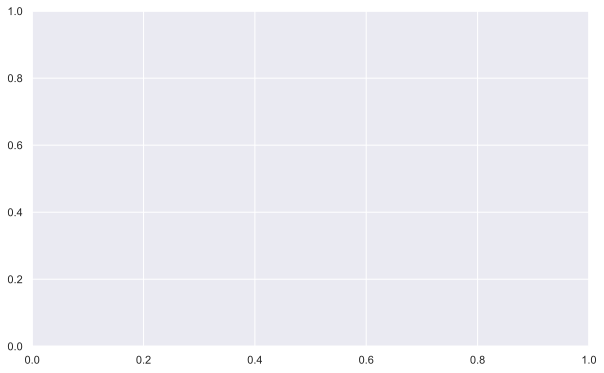

In [26]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
import pandas as pd
import seaborn as sns

df = pd.DataFrame(list(zip(k256,k512,k1024,k2048,k4096)), dtype=float, columns = ['256','512','1024','2048','4096'])
# ic(df.iloc[0])
plt.figure(dpi=1500,figsize=(10,6.18))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df) #, x="per test iterations", y="similarity score"

<AxesSubplot:>

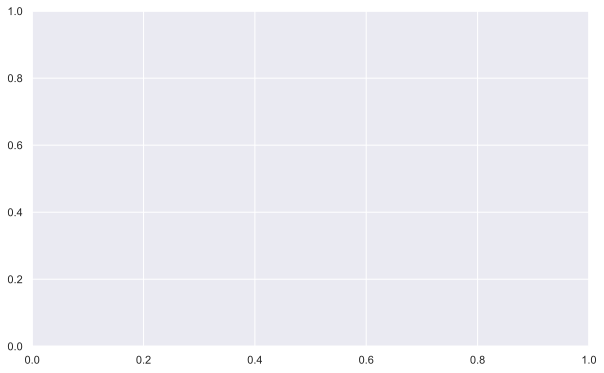

In [27]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
import pandas as pd
import seaborn as sns

df = pd.DataFrame(list(zip(k256,k512,k1024,k2048,k4096)), dtype=float, columns = ['256','512','1024','2048','4096'])
# ic(df.iloc[0])
plt.figure(dpi=1500,figsize=(10,6.18))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df) #, x="per test iterations", y="similarity score"

<AxesSubplot:>

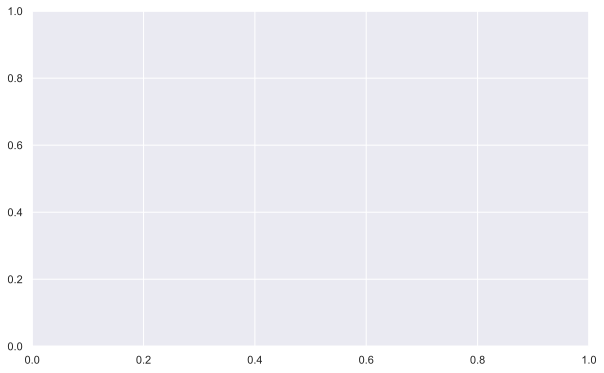

In [28]:
# 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
import pandas as pd
import seaborn as sns

df_cka = pd.DataFrame(trainer.getckalist())

plt.figure(dpi=1500,figsize=(10,6.18))
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(data=df_cka)

# 2. Eval Model on STS Task

## Step 2.1. prepare model

In [ ]:
from mocose import *

In [ ]:
model = MoCoSEModel.from_pretrained('F:\\Experiment\\MoCoSE\\codes\\trained_models\\mocose-bert-base-uncased')

In [ ]:
model = model.cuda()

## Step 2.2 evaluate model

In [ ]:
from mocose_tools import *

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('F:\\Experiment\\MoCoSE\\codes\\pretrained_bert\\bert-base-uncased')

In [ ]:
sum_acc = evalModel(model,tokenizer, pooler = 'cls_before_pooler')

# 3. Eval Model on Transfer Task

## step 3.1 prepare model

In [ ]:
from mocose import *

In [ ]:
model = MoCoSEModel.from_pretrained('mocose-bert-base-uncased')

In [ ]:
model = model.cuda()

## Step 3.2 evaluate model

In [ ]:
from mocose_tools import *

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('F:\\model\\bert-base-uncased')

In [ ]:
sum_acc = evalTransferModel(model,tokenizer, pooler = 'cls_before_pooler')